In [1]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)

def augment_audio(audio, sr=22050):
    shift = np.random.randint(low=-5, high=5)
    audio = np.roll(audio, shift)
    
    noise = np.random.randn(len(audio))
    audio = audio + 0.006 * noise  
    
    pitch = np.random.randint(low=-3, high=3)
    audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=pitch)
    
    stretch = np.random.uniform(low=0.8, high=1.2)
    audio = librosa.effects.time_stretch(audio, rate=stretch)
    
    return audio

ravdess_dir = 'Audio_Speech_Actors_01-24/'
tess_dir = 'TESS Toronto emotional speech set data/'

emotions = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
tess_emotions = {'angry': 'angry', 'disgust': 'disgust', 'fear': 'fearful', 'happy': 'happy', 'neutral': 'neutral', 'ps': 'surprised', 'sad': 'sad'}

labels = []
features = []

# Process RAVDESS dataset
for root, _, files in os.walk(ravdess_dir):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            parts = file.split('-')
            actor_id = int(parts[-1].split('.')[0])
            if actor_id % 2 == 0:  
                emotion = emotions[parts[2]]
                labels.append(emotion)
                features.append(extract_features(file_path))
                
                y, sr = librosa.load(file_path, sr=None)
                augmented_audio = augment_audio(y, sr)
                augmented_feature = librosa.feature.mfcc(y=augmented_audio, sr=sr, n_mfcc=40)
                features.append(np.mean(augmented_feature.T, axis=0))
                labels.append(emotion)

# Process TESS dataset
for root, _, files in os.walk(tess_dir):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            parts = file.split('_')
            emotion = parts[-1].replace('.wav', '')
            emotion = tess_emotions[emotion.lower()]
            labels.append(emotion)
            features.append(extract_features(file_path))
            
            y, sr = librosa.load(file_path, sr=None)
            augmented_audio = augment_audio(y, sr)
            augmented_feature = librosa.feature.mfcc(y=augmented_audio, sr=sr, n_mfcc=40)
            features.append(np.mean(augmented_feature.T, axis=0))
            labels.append(emotion)

# Combine both emotion lists
emotion_list = list(set(emotions.values()).union(set(tess_emotions.values())))
labels = np.array([emotion_list.index(label) for label in labels])

features = np.array(features)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [ ]:
features.shape,labels.shape,X_train.shape,X_test.shape

In [13]:
import numpy as np
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)
     
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint


model = Sequential()

model.add(Conv1D(64, 5,padding='same',input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.Adam(learning_rate=0.001)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 40, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 10, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 2, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,672 (819.03 KB)

 Trainable params: 209,672 (819.03 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
x_traincnn.shape, x_testcnn.shape


((10112, 40, 1), (2528, 40, 1))

In [15]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
     

history=model.fit(x_traincnn, y_train, batch_size=32, epochs=35, validation_data=(x_testcnn, y_test))

Epoch 1/35
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5110 - loss: 2.1664 - val_accuracy: 0.8449 - val_loss: 0.4611
Epoch 2/35
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8450 - loss: 0.4569 - val_accuracy: 0.8699 - val_loss: 0.3710
Epoch 3/35
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8629 - loss: 0.3914 - val_accuracy: 0.8817 - val_loss: 0.3182
Epoch 4/35
316/316 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8772 - loss: 0.3522 - val_accuracy: 0.8790 - val_loss: 0.3825
Epoch 5/35
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8873 - loss: 0.3191 - val_accuracy: 0.8857 - val_loss: 0.3155
Epoch 6/35
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8947 - loss: 0.2969 - val_accuracy: 0.9074 - val_loss: 0.2576
Epoch 7/35
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8954 - loss: 0.2801 - val_accuracy: 0.9110 - val_loss: 0.2525
Epoch 8/35
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9087 - loss: 0.2549 - val_ac

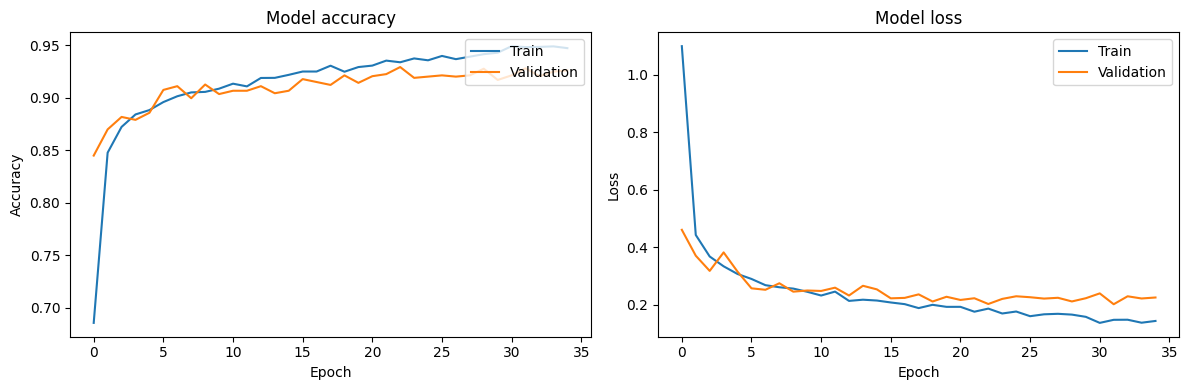

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


In [17]:
loss, accuracy = model.evaluate(x_testcnn, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9248 - loss: 0.2468
Test Accuracy: 92.60%


In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report


y_pred = model.predict(x_testcnn)


print("y_pred shape:", y_pred.shape)
print("y_test shape:", y_test.shape)


if len(y_test.shape) == 1:
    y_test_labels = y_test
else:
    y_test_labels = np.argmax(y_test, axis=1)


if len(y_pred.shape) == 1:
    y_pred_labels = y_pred
else:
    y_pred_labels = np.argmax(y_pred, axis=1)


emotion_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']


y_pred_emotions = [emotion_list[idx] for idx in y_pred_labels]
y_test_emotions = [emotion_list[idx] for idx in y_test_labels]


df_results = pd.DataFrame({
    'Actual Emotion': y_test_emotions,
    'Predicted Emotion': y_pred_emotions
})

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
y_pred shape: (2528, 8)
y_test shape: (2528,)


In [29]:
df_results.head(20)

,Actual Emotion,Predicted Emotion
0,disgust,disgust
1,calm,calm
2,happy,happy
3,disgust,disgust
4,fearful,fearful
5,sad,sad
6,angry,angry
7,calm,calm
8,fearful,fearful
9,happy,happy


In [30]:
report = classification_report(y_test_labels, y_pred_labels, target_names=emotion_list)
print("\nClassification Report:\n", report)



Classification Report:
               precision    recall  f1-score   support

     neutral       0.52      0.84      0.64        38
        calm       0.90      0.92      0.91       357
       happy       0.95      0.92      0.94       365
         sad       0.95      0.95      0.95       364
       angry       0.89      0.92      0.91       331
     fearful       0.95      0.88      0.91       376
     disgust       0.98      0.94      0.96       334
   surprised       0.93      0.96      0.95       363

    accuracy                           0.93      2528
   macro avg       0.88      0.92      0.90      2528
weighted avg       0.93      0.93      0.93      2528



In [35]:
model.save('SER_cnn_model.h5')
